# 1. Setup

In [1]:
import os
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
language = 'English'
data_dir = f'Data/{language}'
train_dir = f'{data_dir}/Train'
val_dir = f'{data_dir}/Val'
test_dir = f'{data_dir}/Test'

In [3]:
cpu_count = 16
print(cpu_count)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

16
cuda


# 2. Define character class

In [4]:
lower_characters = list(string.ascii_lowercase)
upper_characters = list(string.ascii_uppercase)
numbers = [str(i) for i in range(10)]
characters = ['-'] + lower_characters + upper_characters + numbers
print(len(characters))
print(characters)

63
['-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [5]:
idx2char = {k:v for k,v in enumerate(characters)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

{0: '-', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: 'A', 28: 'B', 29: 'C', 30: 'D', 31: 'E', 32: 'F', 33: 'G', 34: 'H', 35: 'I', 36: 'J', 37: 'K', 38: 'L', 39: 'M', 40: 'N', 41: 'O', 42: 'P', 43: 'Q', 44: 'R', 45: 'S', 46: 'T', 47: 'U', 48: 'V', 49: 'W', 50: 'X', 51: 'Y', 52: 'Z', 53: '0', 54: '1', 55: '2', 56: '3', 57: '4', 58: '5', 59: '6', 60: '7', 61: '8', 62: '9'}
{'-': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 35, 'J': 36, 'K': 37, 'L': 38, 'M': 39, 'N': 40, 'O': 41, 'P': 42, 'Q': 43, 'R': 44, 'S': 45, 'T': 46, 'U': 47, 'V': 48, 'W': 49, '

# 3. Define data loader

In [6]:
class IndianSceneTextDataset(Dataset):
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_fns = os.listdir(data_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split("_")[0][:13]
        return image, text, image_fn
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [7]:
trainset = IndianSceneTextDataset(train_dir) 
valset = IndianSceneTextDataset(val_dir) 
testset = IndianSceneTextDataset(test_dir) 
print(len(trainset), len(valset), len(testset))

train_loader = DataLoader(trainset, batch_size=16, num_workers=8, shuffle=True)
val_loader = DataLoader(valset, batch_size=16, num_workers=8, shuffle=False)
test_loader = DataLoader(testset, batch_size=16, num_workers=8, shuffle=False)
print(len(train_loader), len(val_loader), len(test_loader))

500000 5000 5000
31250 313 313


In [8]:
image_batch, text_batch, image_fn_batch = iter(train_loader).next()
print(image_batch.size())
print(text_batch)

torch.Size([16, 3, 50, 200])
('Philology', 'BULLSHITTING', 'roseland', 'rollicked', 'Replicate', 'commies', 'Looters', 'Buccaneering', 'MEADE', 'NORTHROP', 'Transformatio', 'TININESS', 'rarefied', 'Affidavits', 'feasting', 'merchandised')


In [9]:
def tokenize(text):

    text_tokens = list(text)
    
    return text_tokens

In [10]:
for text in text_batch:
    print(text, tokenize(text))

Philology ['P', 'h', 'i', 'l', 'o', 'l', 'o', 'g', 'y']
BULLSHITTING ['B', 'U', 'L', 'L', 'S', 'H', 'I', 'T', 'T', 'I', 'N', 'G']
roseland ['r', 'o', 's', 'e', 'l', 'a', 'n', 'd']
rollicked ['r', 'o', 'l', 'l', 'i', 'c', 'k', 'e', 'd']
Replicate ['R', 'e', 'p', 'l', 'i', 'c', 'a', 't', 'e']
commies ['c', 'o', 'm', 'm', 'i', 'e', 's']
Looters ['L', 'o', 'o', 't', 'e', 'r', 's']
Buccaneering ['B', 'u', 'c', 'c', 'a', 'n', 'e', 'e', 'r', 'i', 'n', 'g']
MEADE ['M', 'E', 'A', 'D', 'E']
NORTHROP ['N', 'O', 'R', 'T', 'H', 'R', 'O', 'P']
Transformatio ['T', 'r', 'a', 'n', 's', 'f', 'o', 'r', 'm', 'a', 't', 'i', 'o']
TININESS ['T', 'I', 'N', 'I', 'N', 'E', 'S', 'S']
rarefied ['r', 'a', 'r', 'e', 'f', 'i', 'e', 'd']
Affidavits ['A', 'f', 'f', 'i', 'd', 'a', 'v', 'i', 't', 's']
feasting ['f', 'e', 'a', 's', 't', 'i', 'n', 'g']
merchandised ['m', 'e', 'r', 'c', 'h', 'a', 'n', 'd', 'i', 's', 'e', 'd']


# 4. Define model

In [11]:
resnet = resnet18(pretrained=True)
#print(resnet)

In [12]:
for p in resnet.parameters():
    pass#p.requires_grad = False

In [13]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dp1 = nn.Dropout(p=0.5)
        self.dp2 = nn.Dropout(p=0.5)
        self.dp3 = nn.Dropout(p=0.5)
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            num_layers=2,
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True,
                            num_layers=1, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        batch = self.dp1(batch)
        # print(batch.size())# torch.Size([-1, 256, 4, 13])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 13, 256, 4])
        
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 13, 1024])
        
        batch = self.linear1(batch)
        batch = self.dp2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn2(batch)
        batch = self.dp3(batch)
        # print(batch.size()) # torch.Size([-1, 13, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 375])
        
        batch = batch.permute(1, 0, 2) # [T, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([13, -1, 375])
        
        return batch

In [14]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [15]:
crnn = CRNN(num_chars=len(char2idx), rnn_hidden_size=256)
#crnn.apply(weights_init)
crnn = crnn.to(device)

In [16]:
#crnn

In [17]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('Philology', 'BULLSHITTING', 'roseland', 'rollicked', 'Replicate', 'commies', 'Looters', 'Buccaneering', 'MEADE', 'NORTHROP', 'Transformatio', 'TININESS', 'rarefied', 'Affidavits', 'feasting', 'merchandised')
torch.Size([13, 16, 63])


In [18]:
#text_batch_logits.log_softmax(2)

# 5. Define loss

In [19]:
criterion = nn.CTCLoss(blank=0)

In [20]:
def encode_text_batch(text_batch):
    
    text_batch = [tokenize(text) for text in text_batch]
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = []
    for text in text_batch:
        for token in text:
            text_batch_concat.append(token)
 
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [21]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [22]:
compute_loss(text_batch, text_batch_logits)

tensor(4.8503, device='cuda:0', grad_fn=<MeanBackward0>)

# 6. Train model

In [23]:
# Hyperparameters: Data Loading
batch_size = 64

# Hyperparameters: Model Architecture
rnn_hidden_size = 256

# Hyperparameters: Training
num_epochs = 30
lr = 0.00081
weight_decay = 1e-5
clip_norm = 5
step_size = 5
gamma = 0.90

In [24]:
trainset = IndianSceneTextDataset(train_dir) 
valset = IndianSceneTextDataset(val_dir) 

train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=8, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, num_workers=8, shuffle=False)

crnn = CRNN(num_chars=len(char2idx), rnn_hidden_size=rnn_hidden_size)
#crnn.apply(weights_init)
crnn = crnn.to(device)

optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [25]:
epoch_losses = []
epoch_losses_val = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    epoch_loss_list_val = []
    num_updates_epoch = 0

    crnn.train()
    for image_batch, text_batch, image_fn_batch in tqdm(train_loader, leave=False, desc="Train"):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()
        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    crnn.eval()
    for image_batch, text_batch, image_fn_batch in tqdm(val_loader, leave=False, desc="Val"):
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()
        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
        epoch_loss_list_val.append(iteration_loss)


    epoch_loss = np.mean(epoch_loss_list)
    epoch_loss_val = np.mean(epoch_loss_list_val)
    print("Epoch:{}    TrainLoss:{}    ValLoss:{}    NumUpdates:{}    LR:{}".\
          format(epoch, epoch_loss, epoch_loss_val, num_updates_epoch, optimizer.param_groups[0]['lr']))
    epoch_losses.append(epoch_loss)
    epoch_losses_val.append(epoch_loss_val)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step()
    
    if epoch % 10 == 0:
        model_path = f'Models/{language}-Unicode-e{epoch}.pth'
        torch.save(crnn.state_dict(), model_path)

Epoch:1    TrainLoss:1.5761620692387137    ValLoss:0.8363045642647562    NumUpdates:7813    LR:0.00081


Epoch:2    TrainLoss:0.8095053293847495    ValLoss:0.6860955512221856    NumUpdates:7813    LR:0.00081


Epoch:3    TrainLoss:0.7030564053338147    ValLoss:0.6492448855615869    NumUpdates:7813    LR:0.00081


Epoch:4    TrainLoss:0.6483212027440803    ValLoss:0.5970052624050575    NumUpdates:7813    LR:0.00081


Epoch:5    TrainLoss:0.6103709949778637    ValLoss:0.5761963175963375    NumUpdates:7813    LR:0.00081


Epoch:6    TrainLoss:0.5630578783754501    ValLoss:0.5104640314850626    NumUpdates:7813    LR:0.0007289999999999999


Epoch:7    TrainLoss:0.5381746126872148    ValLoss:0.5258559076280533    NumUpdates:7813    LR:0.0007289999999999999


Epoch:8    TrainLoss:0.5174370800298383    ValLoss:0.5021952564203287    NumUpdates:7813    LR:0.0007289999999999999


Epoch:9    TrainLoss:0.504174281212549    ValLoss:0.5233273027063925    NumUpdates:7813    LR:0.0007289999999999999


Epoch:10    TrainLoss:0.4877639368441565    ValLoss:0.48984272344202934    NumUpdates:7813    LR:0.0007289999999999999


Epoch:11    TrainLoss:0.4589156583046907    ValLoss:0.45933887824604785    NumUpdates:7813    LR:0.0006561


Epoch:12    TrainLoss:0.4448170654221074    ValLoss:0.4557621497425097    NumUpdates:7813    LR:0.0006561


Epoch:13    TrainLoss:0.43566824949712313    ValLoss:0.45137053237685676    NumUpdates:7813    LR:0.0006561


Epoch:14    TrainLoss:0.4243219260221237    ValLoss:0.4330748494101476    NumUpdates:7813    LR:0.0006561


Epoch:15    TrainLoss:0.41618186170200705    ValLoss:0.4270497912281676    NumUpdates:7813    LR:0.0006561


Epoch:16    TrainLoss:0.39561617248066405    ValLoss:0.40822534027356133    NumUpdates:7813    LR:0.0005904899999999999


Epoch:17    TrainLoss:0.3866881345353785    ValLoss:0.39350784692583207    NumUpdates:7813    LR:0.0005904899999999999


Epoch:18    TrainLoss:0.3788285217468784    ValLoss:0.381836817045755    NumUpdates:7813    LR:0.0005904899999999999


Epoch:19    TrainLoss:0.37204352836079896    ValLoss:0.3702046303903755    NumUpdates:7813    LR:0.0005904899999999999


Epoch:20    TrainLoss:0.36696585102997836    ValLoss:0.3724503815174103    NumUpdates:7813    LR:0.0005904899999999999


Epoch:21    TrainLoss:0.34955983769931026    ValLoss:0.38894716367314136    NumUpdates:7813    LR:0.000531441


Epoch:22    TrainLoss:0.34265058882449634    ValLoss:0.37002648658390286    NumUpdates:7813    LR:0.000531441


Epoch:23    TrainLoss:0.3361433713838628    ValLoss:0.3739641247953795    NumUpdates:7813    LR:0.000531441


Epoch:24    TrainLoss:0.3289812549216317    ValLoss:0.37202197086961963    NumUpdates:7813    LR:0.000531441


Epoch:25    TrainLoss:0.32607965908384834    ValLoss:0.35895168837867203    NumUpdates:7813    LR:0.000531441


Epoch:26    TrainLoss:0.30880129151022434    ValLoss:0.337092203170627    NumUpdates:7813    LR:0.0004782969


Epoch:27    TrainLoss:0.3029726697266689    ValLoss:0.34546553121903273    NumUpdates:7813    LR:0.0004782969


Epoch:28    TrainLoss:0.29694363532825574    ValLoss:0.3545771365678763    NumUpdates:7813    LR:0.0004782969


Epoch:29    TrainLoss:0.2923822421063218    ValLoss:0.35212586079783076    NumUpdates:7813    LR:0.0004782969


Epoch:30    TrainLoss:0.2879751032390226    ValLoss:0.35408844930838934    NumUpdates:7813    LR:0.0004782969



In [26]:
model_path = f'Models/{language}-Unicode.pth'
torch.save(crnn.state_dict(), model_path)

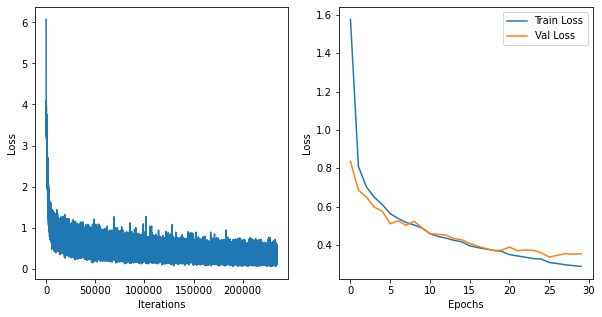

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(iteration_losses)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")

ax2.plot(epoch_losses, label="Train Loss")
ax2.plot(epoch_losses_val, label="Val Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")

plt.legend()
plt.show()

# 7. Make predictions

In [28]:
#trainset = IndianSceneTextDataset(train_dir) 
#valset = IndianSceneTextDataset(val_dir)
testset = IndianSceneTextDataset(test_dir) 

#train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=8, shuffle=False)
#val_loader = DataLoader(valset, batch_size=batch_size, num_workers=8, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=8, shuffle=False)

In [29]:
model_path = f'Models/{language}-Unicode.pth'

crnn = CRNN(len(char2idx), rnn_hidden_size=rnn_hidden_size)
crnn.load_state_dict(torch.load(model_path))
crnn = crnn.to(device)

In [30]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [31]:
def make_predictions(data_loader):
    result = pd.DataFrame(columns=['image_fn', 'actual', 'prediction'])
    with torch.no_grad():
        for image_batch, text_batch, image_fn_batch in tqdm(data_loader, leave=False):
            text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            #print(text_batch, text_batch_pred)
            df = pd.DataFrame(columns=['actual', 'prediction'])
            df['image_fn'] = image_fn_batch
            df['actual'] = text_batch
            df['prediction'] = text_batch_pred
            result = pd.concat([result, df])
    result = result.reset_index(drop=True)
    return result

In [32]:
train_result = make_predictions(train_loader)
val_result = make_predictions(val_loader)
test_result = make_predictions(test_loader)

In [33]:
print(train_result.shape)
print(val_result.shape)
print(test_result.shape)
train_result.head()

(500000, 3)
(5000, 3)
(5000, 3)


,image_fn,actual,prediction
0,MAGINOT_98_45999.jpg,MAGINOT,M--A-G-IN-OT-
1,arriving_304_4073.jpg,arriving,aar-r-ivin-g-
2,STIFFLY_483_74689.jpg,STIFFLY,S--TIF-F-L-Y-
3,Apportioning_374_3564.jpg,Apportioning,Ap-parrtiniig
4,Winches_287_86671.jpg,Winches,W--i-n-gh-e-s


In [34]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [35]:
train_result['prediction_corrected'] = train_result['prediction'].apply(correct_prediction)
val_result['prediction_corrected'] = val_result['prediction'].apply(correct_prediction)
test_result['prediction_corrected'] = test_result['prediction'].apply(correct_prediction)

In [36]:
train_result['actual_length'] = train_result['actual'].apply(len)
val_result['actual_length'] = val_result['actual'].apply(len)
test_result['actual_length'] = test_result['actual'].apply(len)

train_result['prediction_length'] = train_result['prediction_corrected'].apply(len)
val_result['prediction_length'] = val_result['prediction_corrected'].apply(len)
test_result['prediction_length'] = test_result['prediction_corrected'].apply(len)

In [37]:
def levenshteinDistance(row):
    
    s1 = row['actual']
    s2 = row['prediction_corrected']
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [38]:
train_result['edit_distance'] = train_result.progress_apply(levenshteinDistance, axis=1)
val_result['edit_distance'] = val_result.apply(levenshteinDistance, axis=1)
test_result['edit_distance'] = test_result.apply(levenshteinDistance, axis=1)

# 8. Evaluate the model

In [39]:
train_accuracy = accuracy_score(train_result['actual'], train_result['prediction_corrected'])
val_accuracy = accuracy_score(val_result['actual'], val_result['prediction_corrected'])
test_accuracy = accuracy_score(test_result['actual'], test_result['prediction_corrected'])
print(train_accuracy, val_accuracy, test_accuracy)

0.768474 0.735 0.7368


In [40]:
for max_edit_distance in range(3+1):
    print("Max Edit Distance", max_edit_distance)
    train_accuracy = (train_result['edit_distance'] <= max_edit_distance).sum() / len(train_result)
    val_accuracy = (val_result['edit_distance'] <= max_edit_distance).sum() / len(val_result)
    test_accuracy = (test_result['edit_distance'] <= max_edit_distance).sum() / len(test_result)
    print(train_accuracy, val_accuracy, test_accuracy)
    print("*"*50)

Max Edit Distance 0
0.768474 0.735 0.7368
**************************************************
Max Edit Distance 1
0.864192 0.8314 0.8374
**************************************************
Max Edit Distance 2
0.901366 0.8768 0.8762
**************************************************
Max Edit Distance 3
0.922192 0.8974 0.9012
**************************************************


In [41]:
def visualize_misclassifications(split='Train', num_samples=20, max_edit_distance=2):
    
    if split == 'Train':
        result = train_result
    elif split == 'Val':
        result = val_result
    elif split == 'Test':
        result = test_result
        
    mask = result['edit_distance'] >= max_edit_distance
    result = result[mask].sample(n = num_samples)
    for row_id, row in result.iterrows():
        info = 'Actual:', row['actual'], 'Prediction:', row['prediction'], \
              'Prediction Corrected:', row['prediction_corrected']
        print(info)
        
        image_fp = f'Data/{language}/{split}/{row["image_fn"]}'
        plt.imshow(Image.open(image_fp))
        plt.axis(False)
        plt.show()
    

('Actual:', 'devalued', 'Prediction:', 'd-au-p-to-e-d', 'Prediction Corrected:', 'dauptoed')


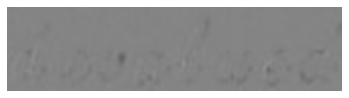

('Actual:', 'KID', 'Prediction:', 'L------------', 'Prediction Corrected:', 'L')


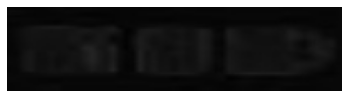

('Actual:', 'HOMOGENEOUSLY', 'Prediction:', 'HOMOEEEEOUSSS', 'Prediction Corrected:', 'HOMOEOUS')


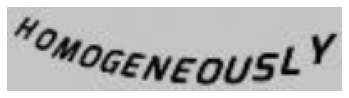

('Actual:', 'clarifying', 'Prediction:', 'd--arif-pin-g', 'Prediction Corrected:', 'darifping')


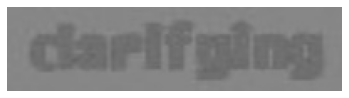

('Actual:', 'Asthmatically', 'Prediction:', 'maiAamaiitiaA', 'Prediction Corrected:', 'maiAamaitiaA')


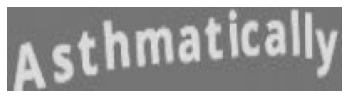

('Actual:', 'sumatra', 'Prediction:', 'S--U-M-A-TR-A', 'Prediction Corrected:', 'SUMATRA')


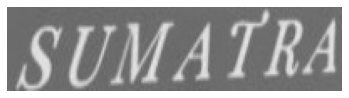

('Actual:', 'Salvation', 'Prediction:', 's-a-l-a-t-en-', 'Prediction Corrected:', 'salaten')


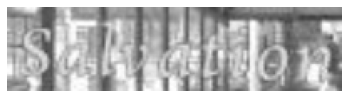

('Actual:', 'oceanographer', 'Prediction:', 'ffoor-grap-st', 'Prediction Corrected:', 'forgrapst')


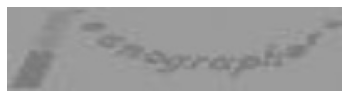

('Actual:', 'tessellation', 'Prediction:', 'ta--iIo-t----', 'Prediction Corrected:', 'taiIot')


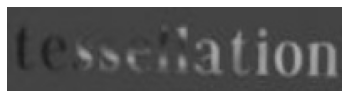

('Actual:', 'EXTRADITION', 'Prediction:', 'EXXTRADIIIOON', 'Prediction Corrected:', 'EXTRADION')


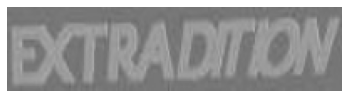

('Actual:', 'curliest', 'Prediction:', 'C-U-R-LIE-ST-', 'Prediction Corrected:', 'CURLIEST')


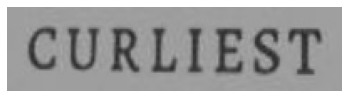

('Actual:', 'ABLATION', 'Prediction:', 'A-B-S-AT-I-ER', 'Prediction Corrected:', 'ABSATIER')


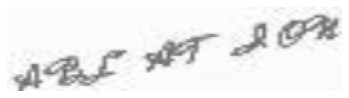

('Actual:', 'Dumpsters', 'Prediction:', 'D-a-m-psio-rs', 'Prediction Corrected:', 'Dampsiors')


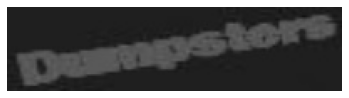

('Actual:', 'scriptwriter', 'Prediction:', 'scriihwwriter', 'Prediction Corrected:', 'scrihwriter')


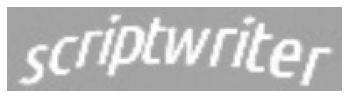

('Actual:', 'Thunderball', 'Prediction:', 'Th-udderval-l', 'Prediction Corrected:', 'Thudervall')


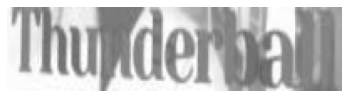

('Actual:', 'seduce', 'Prediction:', 'S--e-d-U-g-e-', 'Prediction Corrected:', 'SedUge')


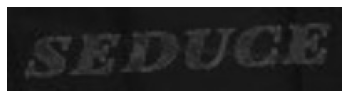

('Actual:', 'reproductive', 'Prediction:', 'T-----e---es-', 'Prediction Corrected:', 'Tees')


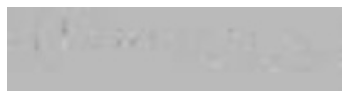

('Actual:', 'Einsteinium', 'Prediction:', 'Ennsttiniu-m-', 'Prediction Corrected:', 'Enstinium')


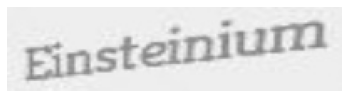

('Actual:', 'covenants', 'Prediction:', 'c-ev-er-an-t-', 'Prediction Corrected:', 'ceverant')


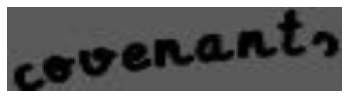

('Actual:', 'pekings', 'Prediction:', 'p--a-ki-n-g--', 'Prediction Corrected:', 'paking')


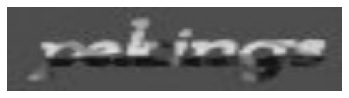

In [42]:
visualize_misclassifications('Train')

('Actual:', 'Vermiform', 'Prediction:', 'N--e-m-f-ordr', 'Prediction Corrected:', 'Nemfordr')


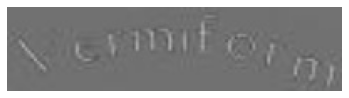

('Actual:', 'oddballs', 'Prediction:', 'e-d-d-baa-lls', 'Prediction Corrected:', 'eddbals')


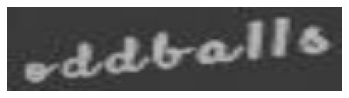

('Actual:', 'EXTRAMURAL', 'Prediction:', 'C-AT-HAM-IRAS', 'Prediction Corrected:', 'CATHAMIRAS')


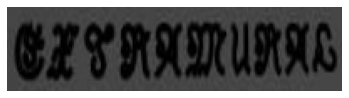

('Actual:', 'Nannys', 'Prediction:', 'N--a-m---y--s', 'Prediction Corrected:', 'Namys')


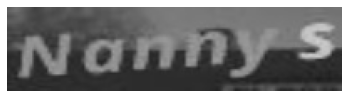

('Actual:', 'BRINKS', 'Prediction:', 'O--D-U-U-K-G-', 'Prediction Corrected:', 'ODUUKG')


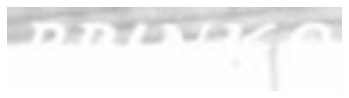

('Actual:', 'MODERATOR', 'Prediction:', 'NODERRA-T-O-N', 'Prediction Corrected:', 'NODERATON')


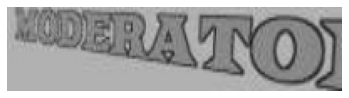

('Actual:', 'APPROBATIONS', 'Prediction:', 'AP-PPOOOAJOO3', 'Prediction Corrected:', 'APPOAJO3')


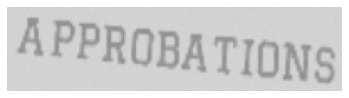

('Actual:', 'Manifolding', 'Prediction:', 'M--anffolDinG', 'Prediction Corrected:', 'ManfolDinG')


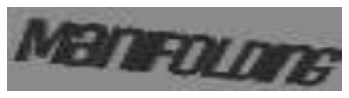

('Actual:', 'generalissimo', 'Prediction:', 'NeammaaiDeEV-', 'Prediction Corrected:', 'NeamaiDeEV')


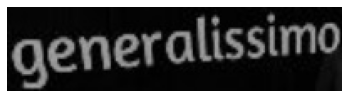

('Actual:', 'inexhaustibly', 'Prediction:', 'mreanagggrggy', 'Prediction Corrected:', 'mreanagrgy')


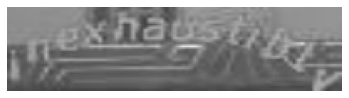

('Actual:', 'DEDICATOR', 'Prediction:', 'P-E--IEC---ER', 'Prediction Corrected:', 'PEIECER')


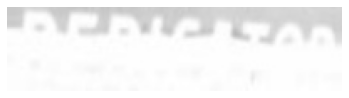

('Actual:', 'Inasmuch', 'Prediction:', 'h--as-m-u-ch-', 'Prediction Corrected:', 'hasmuch')


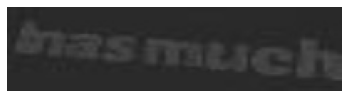

('Actual:', 'preconditione', 'Prediction:', 'preconditiiin', 'Prediction Corrected:', 'preconditin')


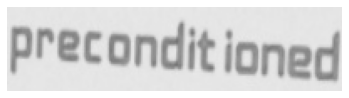

('Actual:', 'SENSUALITY', 'Prediction:', 'T-E-n-ua-a--y', 'Prediction Corrected:', 'TEnuaay')


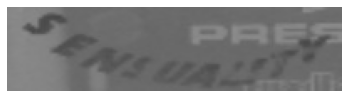

('Actual:', 'FOREDOOMED', 'Prediction:', 'F-OREN-OOMEED', 'Prediction Corrected:', 'FORENOMED')


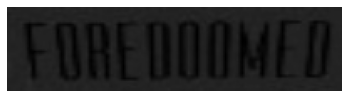

('Actual:', 'Creating', 'Prediction:', 'C--re-dfinng-', 'Prediction Corrected:', 'Credfing')


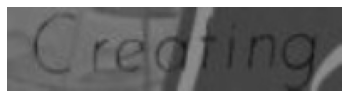

('Actual:', 'REGENT', 'Prediction:', 'P--E-C-EN--T-', 'Prediction Corrected:', 'PECENT')


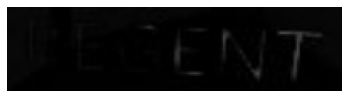

('Actual:', 'puckett', 'Prediction:', 's----s-t-i---', 'Prediction Corrected:', 'ssti')


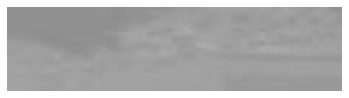

('Actual:', 'smallholdings', 'Prediction:', 'smallholdingg', 'Prediction Corrected:', 'smalholding')


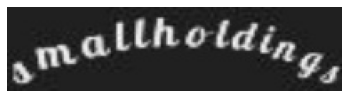

('Actual:', 'GEEZERS', 'Prediction:', 'G--E-R-Z-UR-S', 'Prediction Corrected:', 'GERZURS')


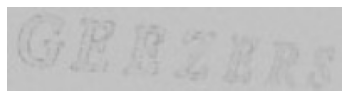

In [43]:
visualize_misclassifications('Val')

('Actual:', 'Personalize', 'Prediction:', 'P-w-o-onslizs', 'Prediction Corrected:', 'Pwoonslizs')


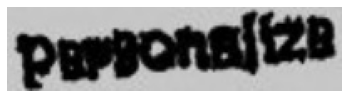

('Actual:', 'BICENTENNIALS', 'Prediction:', 'BCeNIEEEEENAP', 'Prediction Corrected:', 'BCeNIENAP')


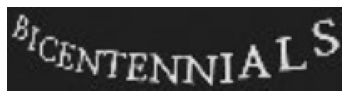

('Actual:', 'inquisitively', 'Prediction:', 'inquisttivell', 'Prediction Corrected:', 'inquistivel')


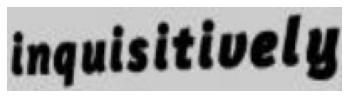

('Actual:', 'STAGNATION', 'Prediction:', 'STaGn-atIo-n-', 'Prediction Corrected:', 'STaGnatIon')


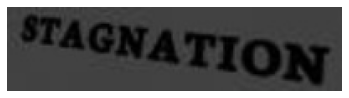

('Actual:', 'nonsectarian', 'Prediction:', 'coseattciiima', 'Prediction Corrected:', 'coseatcima')


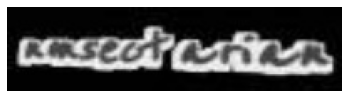

('Actual:', 'cointreau', 'Prediction:', 'c-ol-ntres-s-', 'Prediction Corrected:', 'colntress')


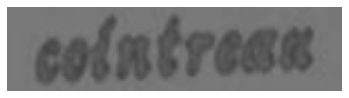

('Actual:', 'DUCKIER', 'Prediction:', 'D--u-Ck-iE-R-', 'Prediction Corrected:', 'DuCkiER')


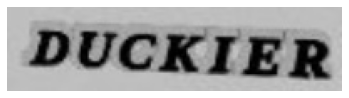

('Actual:', 'THEOLOGICALLY', 'Prediction:', 'UImOIUGaCCmeU', 'Prediction Corrected:', 'UImOIUGaCmeU')


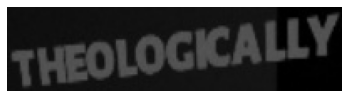

('Actual:', 'OVERTHROWING', 'Prediction:', 'OVERIHROOVING', 'Prediction Corrected:', 'OVERIHROVING')


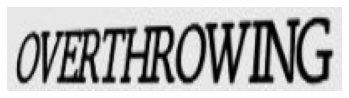

('Actual:', 'bloodthirstin', 'Prediction:', 'bbooddiicihhi', 'Prediction Corrected:', 'bodicihi')


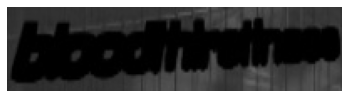

('Actual:', 'Atavist', 'Prediction:', 'A----e-o-l-e-', 'Prediction Corrected:', 'Aeole')


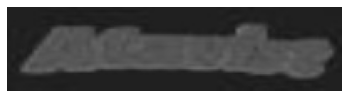

('Actual:', 'INTERCONNECTI', 'Prediction:', 'INTErCOOOEeeC', 'Prediction Corrected:', 'INTErCOEeC')


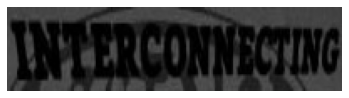

('Actual:', 'Knifing', 'Prediction:', 'R---ai-tia-y-', 'Prediction Corrected:', 'Raitiay')


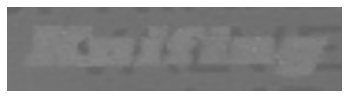

('Actual:', 'occupational', 'Prediction:', 'oo-orm-aaa-ta', 'Prediction Corrected:', 'oormata')


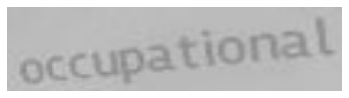

('Actual:', 'Barometric', 'Prediction:', 'B-AR-OM-ETRIC', 'Prediction Corrected:', 'BAROMETRIC')


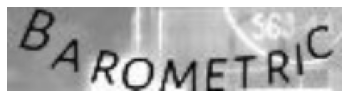

('Actual:', 'WIDER', 'Prediction:', 'D---I--S-E-P-', 'Prediction Corrected:', 'DISEP')


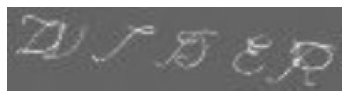

('Actual:', 'NONPLUSSING', 'Prediction:', 'NCUPPUSS-SING', 'Prediction Corrected:', 'NCUPUSSING')


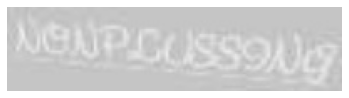

('Actual:', 'CAVIL', 'Prediction:', 'C---A--Y--I--', 'Prediction Corrected:', 'CAYI')


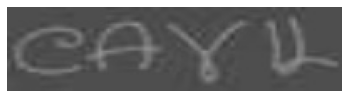

('Actual:', 'secretiveness', 'Prediction:', 'eeTrreeeIeee-', 'Prediction Corrected:', 'eTreIe')


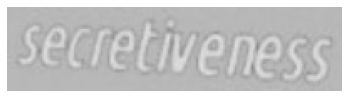

('Actual:', 'PALAZZETTO', 'Prediction:', 'PALAAZZZEITOO', 'Prediction Corrected:', 'PALAZEITO')


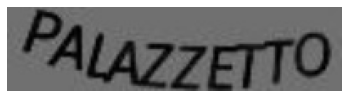

In [44]:
visualize_misclassifications('Test')

### References:
[1] https://github.com/carnotaur/crnn-tutorial/

Loss cannot be reduced beyond 0.54 in val set (after 20 epochs)